<br>

# Técnicas Matemáticas para Big Data - Hidden Markov Models
<br><br>


GROUP 9:
- Inês Matos - Nº 124349 - ??% Work Participation
- João Cardoso - Nº 50750 - ??% Work Participation
- Pedro Rodrigues - Nº 102778 - ??% Work Participation

<br><br>

## 1. Introduction to the problem of study [1,0 valor]

<br><br>
## 2. Brief and general description of the approach and methods used [1,5 valor]

In order to develop an end-to-end system based on Hidden Markov Models capable of modeling the traffic volume in the interstate 94 highway, we followed a structured approach that included the following steps:

1. **Data analysis and preprocessing**: We started by analyzing the dataset and preprocessing it in order to make it suitable for the development of the Hidden Markov Model. As it will be detailed in section 6, the chosen dataset contains both numerical and categorical features. To facilitate the application of the Hidden Markov Model, we decided to encode the numerical features to different categories. Examples of these features are the temperature, the hour of the day, and the traffic volume itself. We also discarded some features that we considered irrelevant as they would not contribute to the model's performance.

2. **Generate the set of possible observations**: As the dataset used is multivariate, which means that it contains multiple features (e.g. temperature, weather, etc.), and since the `hmmlearn` library only accepts a single type of observation (e.g. weather: sunny, rainy, cloudy), we had to generate a set of possible observations. In other words, we had to encode the dataset in such a way that each observation is represented by a single feature.

3. **Map observations and hidden states to integers**: In order to facilitate the implementation of the Hidden Markov Model, we mapped the observations and hidden states to integers. This way, we could use the ```hmmlearn``` library to build the model.

4. **Get the transition matrix and the emission matrix**: As the dataset already contains the traffic volume, we used a subsection of it to calculate the transition matrix and the emission matrix. The transition matrix represents the probability of transitioning from one state to another, while the emission matrix represents the probability of observing a certain feature given a state.

5. **Setup the Hidden Markov Model**: Finally, we created the Hidden Markov Model using the `CategoricalHMM` class from the `hmmlearn` library. We then assigned the transition matrix and the emission matrix to the model.

6. **Model evaluation**: We developed two different scenarios to evaluate the model's performance.

<br><br>
## 3. Brief History and literature review of the problem and methods/algorithms [1,5 valor]

<br><br>
## 4. About the main method/algorithm used [1,5 valor]

<br><br>

## 5. Python imports and global configurations [0,5 valor]

In [1]:
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from hmmlearn import hmm
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

<br><br>

## 6. Dataset and variables explanation [1,5 valor]

The dataset used for this assignment was the "Metro Interstate Traffic Volume" dataset [CITATION_HERE](), available on the UCI Machine Learning Repository. This dataset contains hourly traffic volume data for the Interstate 94 highway in Minneapolis-St Paul, MN, USA. The dataset records traffic volume from 2012-10-02 to 2018-09-30.

This dataset is a multivariate time series dataset, containing 48204 instances and 9 different features. The features and their descriptions are as follows:

| Name                | Description                                       | Type         | Units  |
|---------------------|---------------------------------------------------|--------------|--------|
| holiday             | US National holidays plus regional holiday, Minnesota State Fair | Categorical  |   -     |
| temp                | Average temp in kelvin                            | Continuous   | Kelvin |
| rain_1h             | Amount in mm of rain that occurred in the hour    | Continuous   | mm     |
| snow_1h             | Amount in mm of snow that occurred in the hour    | Continuous   | mm     |
| clouds_all          | Percentage of cloud cover                         | Integer      | %      |
| weather_main        | Short textual description of the current weather  | Categorical  |   -     |
| weather_description | Longer textual description of the current weather | Categorical  |   -     |
| date_time           | Hour of the data collected in local CST time      | Date         |   -     |
| traffic_volume (target)     | Hourly I-94 ATR 301 reported westbound traffic volume | Integer      |   -     |

As mentioned in section 2, in order to use different types of observations in the Hidden Markov Model, we need to create a set of possible observations. This implies that we create all possible combinations of the features in the dataset. In order to reduce the number of possible observations, we only considered the following features: `date-time`, `temperature`, and `weather_main`.

The preprocessing  is presented below.

### Data preprocessing

In [2]:
df = pd.read_csv('METRO Interstate/Metro_Interstate_Traffic_Volume.csv')

- Instead of using the date-time feature as is, we decided to extract the hour of the day from it and then categorize it into 4 different categories: `morning`, `afternoon`, `evening`, and `night`. 

- The temperature feature was also categorized into 5 different categories: `cold`, `cool`, `mild`, `warm`, and `hot`.

- Although the weather_main feature is already categorical, as it can be seen in the plot below, several categories have very few samples. Therefore, we decided to group the categories `Drizzle`, `Haze`, `Thunderstorm`, `Fog`, `Smoke`, and `Squall` into a single category called `other`. Doing this, we reduce the number of possible observations.

- As the traffic volume highly depends if it is weekday or weekend, we decided to create a new feature called `weekend` that indicates if the day is a weekend or not.

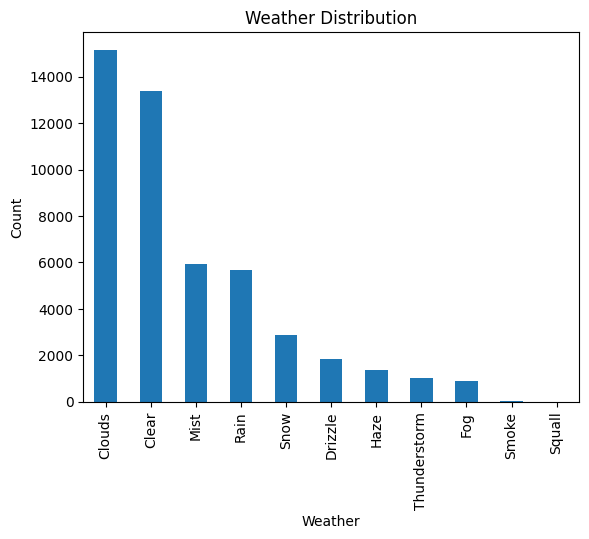

In [3]:
df['weather_main'].value_counts().plot(kind='bar')
plt.xlabel('Weather')
plt.ylabel('Count')
plt.title('Weather Distribution')
plt.show()

In [4]:
time_of_day = {
    "night": range(0, 6),
    "morning": range(6, 12),
    "afternoon": range(12, 18),
    "evening": range(18, 24)
}

temperture = {
    "cold": range(-30, 0),
    "cool": range(0, 10),
    "mild": range(10, 20),
    "warm": range(20, 30),
    "hot": range(30, 50)
}

other_weather = ['Drizzle', 'Haze', 'Fog', 'Thunderstorm', 'Squall', 'Smoke']

In [5]:
def kelvin_to_celsius(k):
    return round(k - 273.15)

def get_time_of_day(x):
    hour = int(x.split(' ')[1].split(':')[0])
    for time_category, time_range in time_of_day.items():
        if hour in time_range:
            return time_category
        
def is_weekend(x):
    date = x.split(' ')[0]
    year, month, day = date.split('-')
    weekday = datetime(int(year), int(month), int(day)).weekday()
    return 1 if weekday >= 5 else 0

def get_temp_category(x):
    for temp_category, temp_range in temperture.items():
        if x in temp_range:
            return temp_category

def convert_weather(x):
    return 'other' if x in other_weather else x.lower()

In [6]:
df['temp'] = df['temp'].apply(kelvin_to_celsius)
df = df[df['temp'] > -50] # remove outliers

df['temp'] = df['temp'].apply(get_temp_category)
df['time_of_day'] = df['date_time'].apply(get_time_of_day)
df['weekend'] = df['date_time'].apply(is_weekend)
df['weather'] = df['weather_main'].apply(convert_weather)

df = df.drop(columns=['date_time', 'holiday', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'weather_description'])
order = ['temp', 'time_of_day', 'weather', 'weekend', 'traffic_volume']
df = df[order]

### Categorize the traffic volume

In order to categorize the traffic volume, we took in consideration the quartiles of the traffic volume. 

The traffic volume was categorized into 4 different categories: `low`, `medium`, `high`, and `very high`:
- `low`: traffic volume < 1193
- `medium`: 1193 <= traffic volume < 3380
- `high`: 3380 <= traffic volume < 4933
- `very high`: traffic volume >= 4933


In [7]:
q1 = df['traffic_volume'].quantile(0.25).astype(int)
q2 = df['traffic_volume'].quantile(0.5).astype(int)
q3 = df['traffic_volume'].quantile(0.75).astype(int)
print(q1, q2, q3)

1194 3380 4933


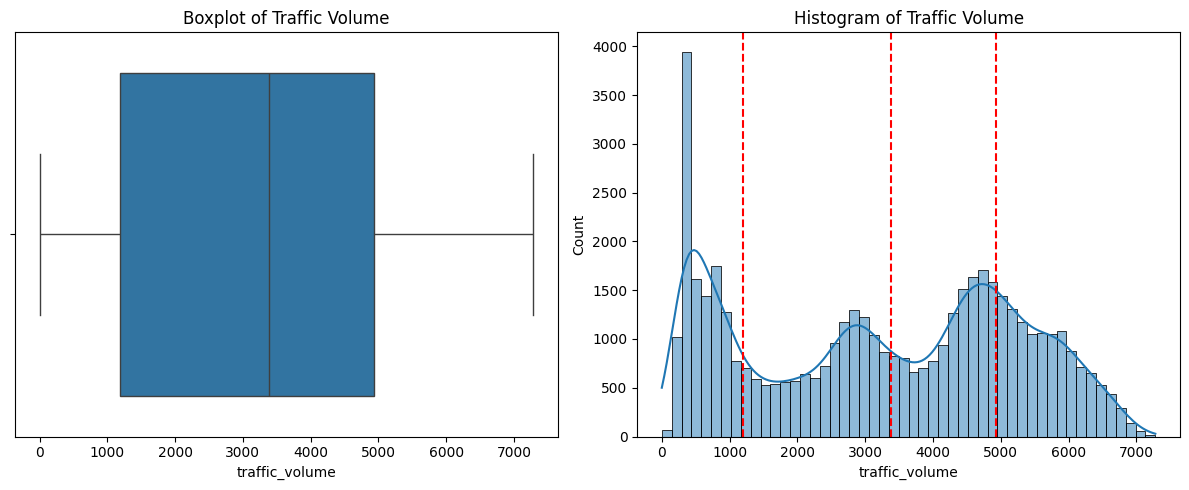

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot
sns.boxplot(x='traffic_volume', data=df, ax=axes[0])
axes[0].set_title('Boxplot of Traffic Volume')

# Histogram
sns.histplot(df['traffic_volume'], bins=50, ax=axes[1], kde=True)
axes[1].set_title('Histogram of Traffic Volume')

# Quartiles
for q in [q1, q2, q3]:
    plt.axvline(q, color='r', linestyle='--')

plt.tight_layout()
plt.show()

In [9]:
min_traffic = df['traffic_volume'].min()
max_traffic = df['traffic_volume'].max()

traffic_categories = {
    'low_volume': (min_traffic, q1),
    'medium_volume': (q1, q2),
    'high_volume': (q2, q3),
    'very_high_volume': (q3, max_traffic + 1)
}

def categorize_traffic_volume(volume):
    volume = int(volume)
    for category, (lower, upper) in traffic_categories.items():
        if lower <= volume < upper:
            return category
        
df['traffic_volume_category'] = df['traffic_volume'].apply(categorize_traffic_volume)

In [10]:
df.to_csv('data/metro_interstate_traffic_volume_processed.csv', index=False)

<br><br>

## 7. Main code as possible solution to the problem [1,5 valor] 

### Split the dataset
We start by splitting the dataset into training and testing sets. We use the first 80% of the dataset to calculate the transition matrix and the emission matrix, and the remaining 20% to evaluate the model.

In [11]:
X = df.drop(columns=['traffic_volume', 'traffic_volume_category'])
y = df['traffic_volume_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

### Generate the set of possible observations

To obtain the set of possible observations, we generate all possible combinations of the features `weekend`, `time_of_day`, `weather`, and `temperature`. We then map these combinations to integers as the `hmmlearn` library only accepts integers as observations.

After some testing, we found that the model performs better without the `temperature` feature. Therefore, we decided to remove it from the set of possible observations.

In [12]:
day_of_week_categories = ['weekday', 'weekend']
time_of_day_categories = df['time_of_day'].unique()
weather_categories = df['weather'].unique()
temp_categories = df['temp'].unique()
traffic_categories = df['traffic_volume_category'].unique()

observations = list(product(day_of_week_categories, time_of_day_categories, weather_categories))
observations = ['_'.join(obs) for obs in observations]

print("Example of observations:")
for obs in observations[:10]:
    print(obs)
print("\nTotal number of observations:", len(observations))

Example of observations:
weekday_morning_clouds
weekday_morning_clear
weekday_morning_rain
weekday_morning_other
weekday_morning_mist
weekday_morning_snow
weekday_afternoon_clouds
weekday_afternoon_clear
weekday_afternoon_rain
weekday_afternoon_other

Total number of observations: 48


### Mapping the observations and traffic states to integers

In [13]:
observations_map = {
    obs: i for i, obs in enumerate(observations)
}

state_map = {
    state: i for i, state in enumerate(traffic_categories)
}


def get_observation(row):
    weekday = 'weekend' if row['weekend'] == 1 else 'weekday'
    obs = f"{weekday}_{row['time_of_day']}_{row['weather']}"
    return observations_map[obs]

def get_sequence(data):
    return data.apply(get_observation, axis=1).values.reshape(-1, 1)

### Transition and emission probabilities

As already mentioned, as we already know the traffic volume category for each instance, we took this as advantage to model the system. We used the train subsection of the dataset to calculate the transition matrix and the emission matrix. Additionally, we also calculated the initial state distribution.

In [14]:
def transition_matrix(n_states, states_sequence):
    transition_counts = np.zeros((n_states, n_states))
    for (i, j) in zip(states_sequence[:-1], states_sequence[1:]):
        transition_counts[i, j] += 1

    transition_probs = transition_counts / transition_counts.sum(axis=1, keepdims=True)
    return transition_probs


def emission_matrix(n_states, n_observations, states_sequence, observations_sequence):
    emission_counts = np.zeros((n_states, n_observations))
    for state, obs in zip(states_sequence, observations_sequence):
        emission_counts[state, obs] += 1

    emission_probs = emission_counts / emission_counts.sum(axis=1, keepdims=True)
    return emission_probs


def start_probs(n_states, states_sequence):
    start_counts = Counter(states_sequence)
    start_probs = np.array([start_counts[state] for state in range(n_states)])
    start_probs = start_probs / start_probs.sum()
    return start_probs

In [15]:
n_states = len(traffic_categories)
n_observations = len(observations)

states_sequence = y_train.map(state_map).values
observations_sequence = get_sequence(X_train)

# Transition matrix
transition_probs = transition_matrix(n_states, states_sequence)

# Emission matrix
emission_probs = emission_matrix(n_states, n_observations, states_sequence, observations_sequence)

# Start probability
start_probs = start_probs(n_states, states_sequence)

In [16]:
print("Transition matrix:")
for row in transition_probs:
    for prob in row:
        print(f"{prob:.2f}", end=' ')
    print()
    
print("\nEmission matrix:")
for row in emission_probs:
    for prob in row:
        print(f"{prob:.2f}", end=' ')
    print()

print("\nStart probability:")
for prob in start_probs:
    print(f"{prob:.2f}", end=' ')
print()

Transition matrix:
0.78 0.21 0.01 0.00 
0.12 0.71 0.16 0.00 
0.09 0.07 0.68 0.15 
0.01 0.00 0.14 0.84 

Emission matrix:
0.13 0.11 0.05 0.05 0.08 0.02 0.23 0.13 0.07 0.05 0.03 0.02 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.09 0.06 0.03 0.03 0.04 0.02 0.06 0.03 0.02 0.02 0.01 0.02 0.07 0.05 0.02 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.03 0.03 0.01 0.01 0.01 0.00 0.10 0.06 0.03 0.02 0.02 0.01 0.03 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.01 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.16 0.14 0.06 0.04 0.04 0.03 0.03 0.03 0.01 0.01 0.02 0.01 0.04 0.04 0.01 0.02 0.02 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.06 0.06 0.02 0.02 0.02 0.01 0.01 0.01 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.02 0.01 0.01 0.01 0.00 0.16 0.18 0.07 0.07 0.10 0.04 0.01 0.01 0.01 0.01 0.01 0.00 0.00 0

### Create HMM model

Given the transition matrix, the emission matrix, and the initial state distribution, we created the Hidden Markov Model using the `CategoricalHMM` class from the `hmmlearn` library.

In [17]:
model = hmm.CategoricalHMM(n_components=n_states)
model.startprob_ = start_probs
model.transmat_ = transition_probs
model.emissionprob_ = emission_probs

<br><br>

## 8. Analysis of Example 1 [3,0 valor]

<br><br>

## 9. Analysis of Example 2 [3,0 valor]

<br><br>
## 10. Pros and cons of the approach [2,0 valor]

<br><br>
## 11. Future improvements [2,0 valor]

<br>
<div style="text-align: center;">
    <br><br>
    <p style="font-size: 40px;">References [1,0 valor]</p>
</div>
<br>
